In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget


In [2]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.01), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

In [55]:
# b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/square/no_perception/2022-11-08-11-56-31.bag')
b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/mission/no_perception/2022-11-08-11-19-46.bag')
b.topic_table

[INFO]  Data folder /Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/mission/no_perception/2022-11-08-11-19-46 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,2517,31.299375
1,/anafi/gnss_location,sensor_msgs/NavSatFix,2517,31.025712
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,5030,948.293918
3,/anafi/gnss_ned_in_body_frame/1hz,geometry_msgs/PointStamped,81,0.975943
4,/anafi/height,olympe_bridge/Float32Stamped,2517,31.183953
5,/anafi/image,sensor_msgs/Image,2517,31.422715
6,/anafi/ned_pose_from_gnss,geometry_msgs/PointStamped,2516,31.460898
7,/anafi/odometry,nav_msgs/Odometry,2516,22.870703
8,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,2516,31.370306
9,/anafi/polled_body_velocities,geometry_msgs/TwistStamped,414,5.018965


# Compare GT vs Anafi attitude

In [56]:
anafi_attitude = b.message_by_topic('/anafi/pose')
df_anafi_attitude = pd.read_csv(anafi_attitude)

df_anafi_attitude = df_from_pose_to_euler(df_anafi_attitude)

df_anafi_attitude = rename_columns(df_anafi_attitude, ["anafi_roll", "anafi_pitch", "anafi_yaw"])

df_anafi_attitude


,Time,anafi_roll,anafi_pitch,anafi_yaw
0,1.667903e+09,-0.717590,6.086433,31.334273
1,1.667903e+09,-0.718692,6.079466,31.347690
2,1.667903e+09,-0.715872,6.086340,31.363253
3,1.667903e+09,-0.716393,6.086066,31.354582
4,1.667903e+09,-0.710819,6.084547,31.334672
...,...,...,...,...
2485,1.667903e+09,-0.737138,5.910050,30.348388
2486,1.667903e+09,-0.735298,5.916789,30.348504
2487,1.667903e+09,-0.735298,5.916789,30.348504
2488,1.667903e+09,-0.742082,5.918618,30.348114


In [57]:
gt_anafi_attitude = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_attitude = pd.read_csv(gt_anafi_attitude)

df_gt_anafi_attitude = df_from_pose_to_euler(df_gt_anafi_attitude)
df_gt_anafi_attitude = rename_columns(df_gt_anafi_attitude, ["gt_anafi_roll", "gt_anafi_pitch", "gt_anafi_yaw"])

df_gt_anafi_attitude

,Time,gt_anafi_roll,gt_anafi_pitch,gt_anafi_yaw
0,1.667903e+09,-0.420508,5.947054,36.761134
1,1.667903e+09,-0.580735,5.970470,36.692811
2,1.667903e+09,-0.615873,5.990032,36.680618
3,1.667903e+09,-0.736180,6.072512,36.650879
4,1.667903e+09,-0.795586,6.062226,36.655451
...,...,...,...,...
8410,1.667903e+09,-0.056740,6.387002,32.813447
8411,1.667903e+09,-0.133859,6.450333,32.802810
8412,1.667903e+09,0.013771,6.536004,32.783926
8413,1.667903e+09,0.001454,6.491472,32.804719


In [58]:
df_merged_attitude = sync_dfs_based_on_time([df_gt_anafi_attitude, df_anafi_attitude])

df_merged_attitude = normalize_df_time(df_merged_attitude)

df_merged_attitude


np_gt_anafi_attitude = get_np_arr_without_nan(df_merged_attitude, ["gt_anafi_roll",	"gt_anafi_pitch",	"gt_anafi_yaw"])
np_anafi_attitude = get_np_arr_without_nan(df_merged_attitude, ["anafi_roll",	"anafi_pitch",	"anafi_yaw"])


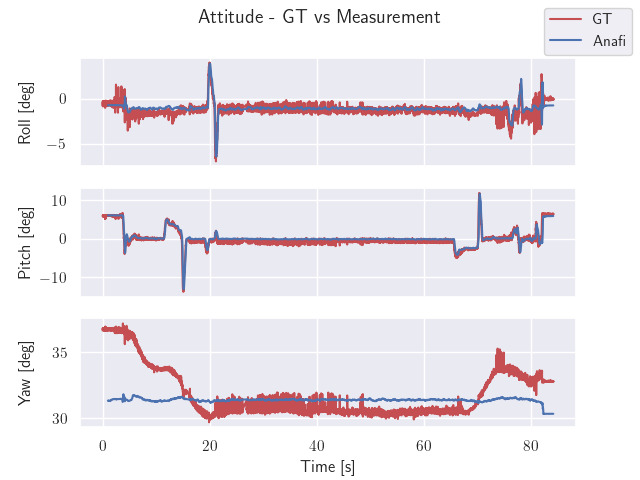

In [60]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,1],'-', ms=1, c='r')
axs[0].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,1],'-', ms=1, c='b')

axs[0].set_ylabel('Roll [deg]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,2],'-', ms=1, c='r')
axs[1].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,2],'-', ms=1, c='b')

axs[1].set_xticklabels([])
axs[1].set_ylabel('Pitch [deg]')
axs[1].grid(True)
axs[1].set_xticklabels([])



axs[2].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,3],'-', ms=1, c='r')
axs[2].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,3],'-', ms=1, c='b')

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Yaw [deg]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Check GT angular velocity

In [54]:
gt_anafi_odom = b.message_by_topic('/qualisys/Anafi/odom')
df_gt_anafi_odom = pd.read_csv(gt_anafi_odom)

df_gt_anafi_odom

df_gt_anafi_odom = rename_columns(df_gt_anafi_odom[["Time", "twist.twist.angular.x", "twist.twist.angular.y", "twist.twist.angular.z"]], ["angular_vel_x", "angular_vel_y", "angular_vel_z"])

df_gt_anafi_odom


,Time,angular_vel_x,angular_vel_y,angular_vel_z
0,1.667905e+09,-0.058379,-0.042115,0.051797
1,1.667905e+09,-0.059845,0.058319,0.007099
2,1.667905e+09,-0.036521,0.031610,0.001113
3,1.667905e+09,0.134935,-0.073187,-0.043923
4,1.667905e+09,0.075616,-0.102691,0.000250
...,...,...,...,...
6858,1.667905e+09,0.009408,0.049653,0.008595
6859,1.667905e+09,-0.011734,-0.033504,0.005683
6860,1.667905e+09,0.027687,0.004784,-0.004426
6861,1.667905e+09,0.065878,-0.000641,-0.012937


In [49]:
df_merged_odom = sync_dfs_based_on_time([df_gt_anafi_odom])

df_merged_odom = normalize_df_time(df_merged_odom)

np_gt_anafi_odom = get_np_arr_without_nan(df_merged_odom, ["angular_vel_x", "angular_vel_y", "angular_vel_z"])


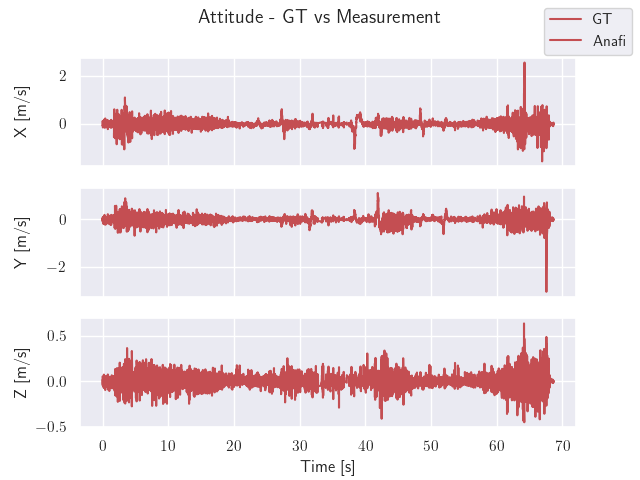

In [52]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,1],'-', ms=1, c='r')

axs[0].set_ylabel('X [m/s]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,2],'-', ms=1, c='r')

axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m/s]')
axs[1].grid(True)
axs[1].set_xticklabels([])



axs[2].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,3],'-', ms=1, c='r')

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m/s]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()